# Backtesting a Futures Trading Strategy (Long-Short) with Leverage

Trading Strategy: __Triple SMA Crossover__ (see Section 15: Ultimate Homework Challenge)

## The underlying historical data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("bitcoin.csv", parse_dates = ["Date"], index_col = "Date")
data

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36168 entries, 2017-08-17 04:00:00 to 2021-10-07 09:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    36168 non-null  float64
 1   High    36168 non-null  float64
 2   Low     36168 non-null  float64
 3   Close   36168 non-null  float64
 4   Volume  36168 non-null  float64
dtypes: float64(5)
memory usage: 1.7 MB


-> Spot Prices (without Funding Rate data)

## Recap: Backtesting without Leverage

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [6]:
class Long_Short_Backtester():
    ''' Class for the vectorized backtesting of simple Long-Short trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, smas):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        smas: tuple (SMA_S, SMA_M, SMA_L)
            Simple Moving Averages to be considered for the strategy.
            
        '''
        
        self.SMA_S = smas[0]
        self.SMA_M = smas[1]
        self.SMA_L = smas[2]
        
        
        self.prepare_data(smas = smas)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, smas):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "returns"]].copy()
        data["SMA_S"] = data.Close.rolling(window = smas[0]).mean()
        data["SMA_M"] = data.Close.rolling(window = smas[1]).mean()
        data["SMA_L"] = data.Close.rolling(window = smas[2]).mean()
        
        data.dropna(inplace = True)
                
        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
        
        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1

        ##########################################################################
        
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, SMA_S_range, SMA_M_range, SMA_L_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        SMA_S_range: tuple
            tuples of the form (start, end, step size).
        
        SMA_M_range: tuple
            tuples of the form (start, end, step size).
            
        SMA_L_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        SMA_S_range = range(*SMA_S_range)
        SMA_M_range = range(*SMA_M_range)
        SMA_L_range = range(*SMA_L_range)
        
        combinations = list(product(SMA_S_range, SMA_M_range, SMA_L_range))
         
        performance = []
        for comb in combinations:
            self.prepare_data(smas = comb)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["SMA_S", "SMA_M", "SMA_L"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        SMA_S = best.SMA_S.iloc[0]
        SMA_M = best.SMA_M.iloc[0]
        SMA_L = best.SMA_L.iloc[0]
        perf = best.performance.iloc[0]
        print("SMA_S: {} | SMA_M: {} | SMA_L : {} | {}: {}".format(SMA_S, SMA_M, SMA_L, self.metric, round(perf, 5)))  
        self.test_strategy(smas = (SMA_S, SMA_M, SMA_L))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [7]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2021-10-07"
#tc = -0.00085 # average/approx Trading Costs in Spot Market
tc = -0.00050 # average/approx Trading Costs in Futures Market
sma_s = 15 
sma_m = 50 
sma_l = 200 

In [8]:
tester = Long_Short_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)

In [9]:
tester.data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0.002457
...,...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360,0.004058


In [ ]:
tester.test_strategy(smas = (sma_s, sma_m, sma_l))

In [ ]:
tester.plot_results()

In [ ]:
tester.results

In [ ]:
tester.results.trades.value_counts()

## Leverage - a more realistic Approach (non-constant Leverage)

In [ ]:
import pandas as pd
import numpy as np

__Initial Assumption (no leverage): We buy (long) 100 units of an Instrument @ initial price of 1 -> Initial Trade Value: 100__. <br>
__We keep the long position until the end of day 3 (without further trades)__.

In [ ]:
df = pd.DataFrame(data = {"Price": [1, 1.1, 1.25, 1.3], "Units": [100, 100, 100, 100]}, index = [0, 1, 2, 3])
df

In [ ]:
df["Trade_Value"] = df.Price * df.Units # Trade Value over time
df

In [ ]:
df["Returns"] = df.Trade_Value.pct_change() # simple Returns
df

In [ ]:
df["Compound"] = df.Returns.add(1).cumprod() - 1 # compound simple Returns
df

__New Assumption: Same as before but now we trade with leverage of 2 -> We post a Margin of 50 (50% of initial Trade Value)__.

In [ ]:
leverage = 2
leverage

In [ ]:
df["Margin"] = df.Trade_Value[0] / leverage # Margin Account with 50
df

In [ ]:
df["PL_unreal"] = df.Trade_Value - df.Trade_Value[0] # unrealized Profit / Loss of our long position over time
df

In [ ]:
df["Equity"] = df.Margin + df.PL_unreal # our net wealth (Equity) over time == Margin + unreal P&L
df

In [ ]:
df["Equity_Returns"] = df.Equity.pct_change() # simple returns of our Equity position
df

Problem: Typically, we don´t have Margin, PL_unreal & Equity in our DataFrame. -> __Calculate Equity (levered) return with leverage__.

In [ ]:
df.Returns * leverage # try to calculate equity returns with constant leverage -> incorrect as this assumes constant leverage of 2 

In [ ]:
df["EL"] = df.Trade_Value / df.Equity # calculate the effective leverage
df

In [ ]:
df.Returns * df.EL.shift() # try to calculate equity returns with effective leverage -> correct 

__Problem__: Typically we don´t have Trade_Value or Equity in our DataFrame. __How to calculate Effective Leverage__? 

In [ ]:
df["EL2"] = leverage * (1 + df.Compound) / (1 + df.Compound * leverage) # calc. effective leverage with returns 
df["EL2"].fillna(leverage, inplace = True)
df

In [ ]:
levered_returns = df.Returns * df.EL2.shift()
levered_returns

In [ ]:
levered_returns = pd.Series(np.where(levered_returns < -1, -1, levered_returns))
levered_returns

In [ ]:
levered_returns.add(1).cumprod()

__So far:__

__Only one Trading Session__ (hold Long Position for 3 days) <br>
(Trading Session: time period between two trades where traders just hold a position)

Leverage changes in a trading session:
- __Leverage goes down__ when the Price moves into the __right direction__ (long: increase)
- __Leverage goes up__ when the Price moves into the __wrong direction__ (long: decrease) 

Realistic Assumption for Long-Short Strategies: __Restore Target Leverage at the beginning of each trading session.__

How to restore Leverage (if we don´t adjust margin/equity)?
- __reduce Trade Value if leverage > target leverage__
- __increase Trade Value if leverage < target leverage__

## Backtesting with Leverage

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [3]:
class Futures_Backtester():
    ''' Class for the vectorized backtesting of (levered) Futures trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
        
    add_sessions:
        adds/labels trading sessions and their compound returns.
        
    add_leverage:
        adds leverage to the strategy.
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Futures_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, smas):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        smas: tuple (SMA_S, SMA_M, SMA_L)
            Simple Moving Averages to be considered for the strategy.
            
        '''
        
        self.SMA_S = smas[0]
        self.SMA_M = smas[1]
        self.SMA_L = smas[2]
        
        
        self.prepare_data(smas = smas)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, smas):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "returns"]].copy()
        data["SMA_S"] = data.Close.rolling(window = smas[0]).mean()
        data["SMA_M"] = data.Close.rolling(window = smas[1]).mean()
        data["SMA_L"] = data.Close.rolling(window = smas[2]).mean()
        
        data.dropna(inplace = True)
                
        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
        
        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1

        ##########################################################################
        
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self, leverage = False): #Adj!
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        elif leverage: # NEW!
            title = "{} | TC = {} | Leverage = {}".format(self.symbol, self.tc, self.leverage)
            self.results[["creturns", "cstrategy", "cstrategy_levered"]].plot(title=title, figsize=(12, 8))
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
            
    def optimize_strategy(self, SMA_S_range, SMA_M_range, SMA_L_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        SMA_S_range: tuple
            tuples of the form (start, end, step size).
        
        SMA_M_range: tuple
            tuples of the form (start, end, step size).
            
        SMA_L_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        SMA_S_range = range(*SMA_S_range)
        SMA_M_range = range(*SMA_M_range)
        SMA_L_range = range(*SMA_L_range)
        
        combinations = list(product(SMA_S_range, SMA_M_range, SMA_L_range))
         
        performance = []
        for comb in combinations:
            self.prepare_data(smas = comb)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["SMA_S", "SMA_M", "SMA_L"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        SMA_S = best.SMA_S.iloc[0]
        SMA_M = best.SMA_M.iloc[0]
        SMA_L = best.SMA_L.iloc[0]
        perf = best.performance.iloc[0]
        print("SMA_S: {} | SMA_M: {} | SMA_L : {} | {}: {}".format(SMA_S, SMA_M, SMA_L, self.metric, round(perf, 5)))  
        self.test_strategy(smas = (SMA_S, SMA_M, SMA_L))
        
    
    def add_sessions(self, visualize = False): # NEW!!!
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        
        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()  
        
    def add_leverage(self, leverage, report = True): # NEW!!!
        ''' 
        Adds Leverage to the Strategy.
        
        Parameter
        ============
        leverage: float (positive)
            degree of leverage.
        
        report: bool, default True
            if True, print Performance Report incl. Leverage.
        '''
        self.add_sessions()
        self.leverage = leverage
        
        data = self.results.copy()
        data["simple_ret"] = np.exp(data.strategy) - 1
        data["eff_lev"] = leverage * (1 + data.session_compound) / (1 + data.session_compound * leverage)
        data.eff_lev.fillna(leverage, inplace = True)
        data.loc[data.trades !=0, "eff_lev"] = leverage
        levered_returns = data.eff_lev.shift() * data.simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data["strategy_levered"] = levered_returns
        data["cstrategy_levered"] = data.strategy_levered.add(1).cumprod()
        
        self.results = data
            
        if report:
            self.print_performance(leverage = True)
            
    ############################## Performance ######################################
    
    def print_performance(self, leverage = False): # Adj
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        
        if leverage: # NEW!
            to_analyze = np.log(data.strategy_levered.add(1))
        else: 
            to_analyze = data.strategy
            
            
        strategy_multiple = round(self.calculate_multiple(to_analyze), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(to_analyze), 6)
        ann_mean =          round(self.calculate_annualized_mean(to_analyze), 6)
        ann_std =           round(self.calculate_annualized_std(to_analyze), 6)
        sharpe =            round(self.calculate_sharpe(to_analyze), 6)
       
        print(100 * "=")
        print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [4]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2021-10-07"
tc = -0.0005
sma_s = 15 
sma_m = 50 
sma_l = 200 

In [5]:
tester = Futures_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)

In [6]:
tester

Futures_Backtester(symbol = BTCUSDT, start = 2017-08-17, end = 2021-10-07)

In [8]:
tester.data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0.002457
...,...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360,0.004058


In [9]:
tester.test_strategy(smas = (sma_s, sma_m, sma_l))

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         21.847562
Multiple (Buy-and-Hold):     12.515385
--------------------------------------
Out-/Underperformance:       9.332177


CAGR:                        1.115893
Annualized Mean:             0.749158
Annualized Std:              0.733657
Sharpe Ratio:                1.521001


In [10]:
tester.add_leverage(leverage = 2)

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         115.535632
Multiple (Buy-and-Hold):     12.515385
--------------------------------------
Out-/Underperformance:       103.020247


CAGR:                        2.17153
Annualized Mean:             1.153724
Annualized Std:              1.360622
Sharpe Ratio:                1.595983


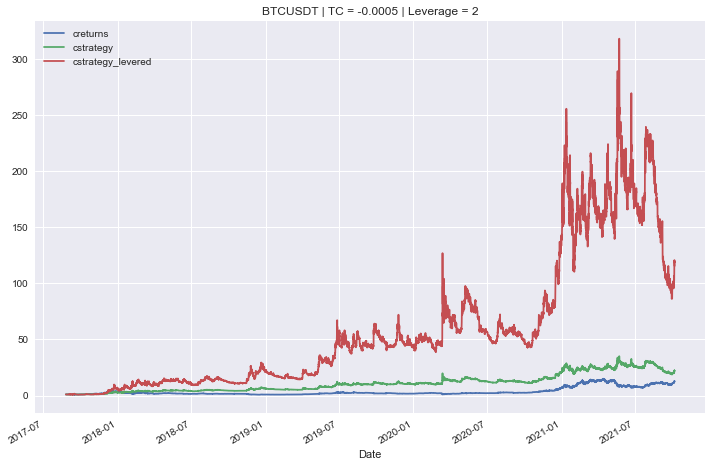

In [11]:
tester.plot_results(leverage = True)

In [ ]:
tester.results

In [ ]:
tester.results.trades.value_counts()

In [ ]:
tester.results.eff_lev.describe()

In [ ]:
tester.results.eff_lev.plot(figsize = (12, 8))
plt.show()

## The Impact of Leverage

In [12]:
tester

Futures_Backtester(symbol = BTCUSDT, start = 2017-08-17, end = 2021-10-07)

__no Leverage__

In [13]:
tester.test_strategy(smas = (sma_s, sma_m, sma_l))

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         21.847562
Multiple (Buy-and-Hold):     12.515385
--------------------------------------
Out-/Underperformance:       9.332177


CAGR:                        1.115893
Annualized Mean:             0.749158
Annualized Std:              0.733657
Sharpe Ratio:                1.521001


__Leverage = 2__

In [14]:
tester.add_leverage(leverage = 2)

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         115.535632
Multiple (Buy-and-Hold):     12.515385
--------------------------------------
Out-/Underperformance:       103.020247


CAGR:                        2.17153
Annualized Mean:             1.153724
Annualized Std:              1.360622
Sharpe Ratio:                1.595983


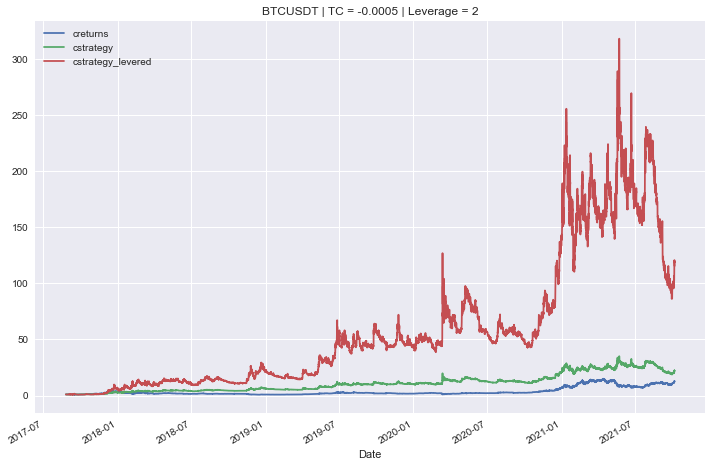

In [15]:
tester.plot_results(leverage = True)

-> Increase Multiple (and Risk)

__further increase Leverage__

In [16]:
tester.add_leverage(leverage = 3)

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         190.222375
Multiple (Buy-and-Hold):     12.515385
--------------------------------------
Out-/Underperformance:       177.70699


CAGR:                        2.580077
Annualized Mean:             1.274842
Annualized Std:              1.935033
Sharpe Ratio:                1.333351


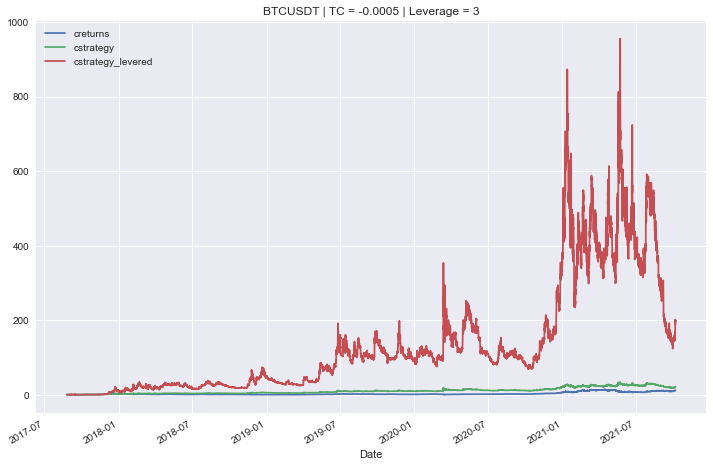

In [17]:
tester.plot_results(leverage = True)

-> at a certain leverage, it´s getting worse!

__extremely high leverage__

In [18]:
tester.add_leverage(leverage = 125)

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.0
Multiple (Buy-and-Hold):     12.515385
--------------------------------------
Out-/Underperformance:       -12.515385


CAGR:                        -1.0
Annualized Mean:             -inf
Annualized Std:              nan
Sharpe Ratio:                nan


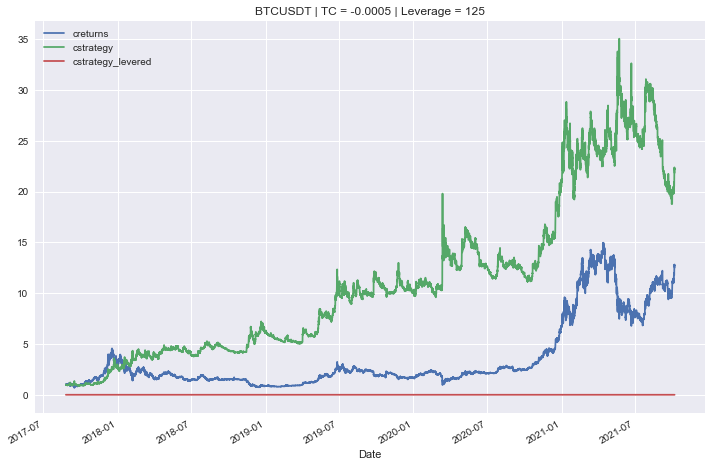

In [19]:
tester.plot_results(leverage = True)

-> total loss (Liquidation) very likely (rather sooner than later)

__Conclusions:__

- Even for (highly) profitable strategies: __"The more leverage the better" does not hold__.
- It´s a two-edged (__non-symmetrical__) sword: __Leverage amplifies losses more than it amplifies gains__.
- Trading Strategies have an __optimal/maximum degree of leverage__ (...and it´s lower than traders think)

Trading Crypto Futures with high leverage (>5) requires:
- Trading Strategies with __very high risk-adjusted returns__ / tail-risk-adjusted returns
- __Advanced Performance and Risk Measurement__
- Advanced __Monitoring__, __Performance Optimization__ and __Risk Management Techniques__
- Experience
- Ability and Willingness to accept __temporary high losses__